### Tutorial 3 - Cross-Parliament Comparison (using Cosine Distance)

**Possible research questions:**
- *Which countries have the most similar sentiment patterns across CAP categories?*
- *How similar are countries in their topic distributions based on word counts?*
- *For a specific CAP category, which countries exhibit the most similar sentiment patterns?*

This tutorial includes:
- **Introduction to Cosine Distance**
    + Explanation: why cosine distance is useful for comparing patterns (e.g. CAP distributions, sentiment profiles)
    + Simple example with vectors 
- **Load, read and filter the Data**
- **Compute cosine distance between countries based on sentiment**
    + Pivot data: rows = country, columns = CAP category, values = mean sentiment
    + Compute cosine distances and create a readable distance DataFrame
    + Visualize the distances using dendrograms
    + Identify the **thre most similar countries** for each country based on cosine distance
- **Compare sentiment across political groupings**
    + Compare CAP category sentiment across all countries, coalition and opposition
    + Visualize the similarity using dendrograms
- **Compare CAP category distributions based on word counts**
    + Pivot data: rows = country, columns = CAP category, values = total word counts
    + Build cosine distance tables and visualize using dendrograms
    + Compare CAP distributions across all countries, coalition, and opposition using **three side-by-side dendrograms**
- **Topic-specific similarity**
    + Focus on a specific CAP category
    + Calculate how similar countries are in terms of sentiment for that category across all countries

#### **1. Introduction to Cosine Distance**
**Cosine Distance** is way of comparing **patterns** between countries, regardless of size. Instead of asking *"which country's parliament has more speeches?"*, it asks *"how similar are their profiles across topics or sentiments?"*.

We turn each country's CAP-category-distribution or CAP x sentiment score - values into a vector and then compare the *angle* between those vectors. 
- If two countries talk about the same topics in similar proportions (or show similar sentiment patterns), their cosine distance is **small** (close together).
- If their focus is very different, the distance is **large** (far apart).

This method lets us:
- Cluster countries into groups with similar discourse (via dendrograms)
- Identify each parliament's "nearest neighbor"
- Compare similarity across all MPs, coalitions or oppositions
- Zoom into specific topics (e.g. *Environment*) to see which countries align or diverge

#### **Example - How Cosine Distance Works**
We look at two countries (A and B) and we want to find out how similar they are in how mcuh they talk about 3 topics: *Education, Health, Environment*.

| Country | Education | Health | Environment |
|---------|--------|--------|-------------|
| A       | 50     | 30     | 20          |
| B       | 100    | 60     | 40          |

--> If we just compared **word counts**, Country B seems like people there talk more about each topic - but that doesn't tell us how **similar** the countries are.

So, we convert them into proportions (distributions):

| Country | Economy | Health | Environment |
|---------|--------|--------|-------------|
| A       | 0.50     | 0.30     | 0.20          |
| B       | 0.50    | 0.30     | 0.20          |

Now, the vectors are:
- A = [0.5, 0.3, 0.2]
- B = [0.5, 0.3, 0.2]

**Cosine Similarity compares the *angle* between vectors:
$$
\text{cosine\_similarity}(A, B) = \frac{A \cdot B}{\|A\| \cdot \|B\|}
$$
- If the vectors point in the **same direction** --> similary = 1 (distance = 0)
- If they are **orthogonal (completely different)** ---> similarity = 0 (distance = 1)

Here: 
- Countries A and B have identical proportions, so cosine similarity = 1
- They are perfectly similar in terms of *distribution across topics*, even though B has more total speeches


**2. Setup**

First, we have to set up the requirements: install and load all necessary packages.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_distances
import csv
from pathlib import Path
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

In [1]:
# Set consistent style
sns.set_theme(style="whitegrid", font_scale=1.2)

NameError: name 'sns' is not defined

**3. Data Loading & Filtering**

Now, we **read and filter** the data. This code:
- loads the selected columns of the datasets and merges them into a single DataFrame.
- selects only those that were held by Regular MPs (*Members of Parliament*) and filters out the CAP categories "Mix" and "Other". 
- creates separate DataFrames for coalition and opposition party speeches.


In [2]:
# ---- 1. First, we have to increase the CSV field size limit ----
max_int = 2**31 - 1
while True:
    try:
        csv.field_size_limit(max_int)
        break
    except OverflowError:
        max_int = max_int // 10

countries = ["AT", "BA", "BE", "BG", "CZ", "DK", "EE", "ES-CT", "ES-GA", "ES-PV", 
             "FR", "GB", "GR", "HR", "HU", "IS", "IT", "LV", 
             "NL", "NO", "PL", "PT", "RS", "SE", "SI", "TR", "UA"] #change country codes according to your available datasets

base_dir = Path().resolve()

# ---- 2. Choose what columns to read (including CAP and sentiment columns) ----
cols_to_keep = [
    "id", "date", "lang_code", "lang", "speaker_role", "speaker_MP",
    "speaker_minister", "speaker_party", "speaker_party_name", "party_status",
    "party_orientation", "speaker_id", "speaker_name", "speaker_gender",
    "speaker_birth", "word_count", "CAP_category", "sent3_category", "sent6_category", "sent_logit"
]

# ---- 3. Define dtypes to reduce memory ----
dtypes = {
    "id": str,
    "date": str,
    "lang_code": "category",
    "lang": "category",
    "speaker_role": "category",
    "speaker_MP": "category",
    "speaker_minister": "category",
    "speaker_party": "category",
    "speaker_party_name": "category",
    "party_status": "category",
    "party_orientation": "category",
    "speaker_id": "category",
    "speaker_name": "category",
    "speaker_gender": "category",
    "speaker_birth": "Int32",
    "word_count": "Int32",
    "CAP_category": "category",
    "sent3_category": "category",
    "sent6_category": "category",
    "sent_logit": "float32"
}

# ---- 4. Create lists to accumulate filtered chunks ----
all_chunks = []

for country in countries:
    file_path = base_dir / f"ParlaMint-{country}_processed_no_text.tsv"

    # --- 4.1. Read in chunks using pandas.read_csv ----
    for chunk in pd.read_csv(file_path, sep="\t", usecols=cols_to_keep,
                             dtype=dtypes, chunksize=50_000, engine="python"):
        chunk["country"] = country
        chunk["country"] = chunk["country"].astype("category")

        # ---- 4.2. Filter MPs with regular role ----
        filtered_chunk = chunk.query("speaker_MP == 'MP' and speaker_role == 'Regular'")

        # ---- 4.3. Drop rows where CAP_category or sentiment is empty ----
        filtered_chunk = filtered_chunk[
            filtered_chunk["CAP_category"].notna() & (filtered_chunk["CAP_category"] != "") &
            filtered_chunk["sent3_category"].notna() & (filtered_chunk["sent3_category"] != "") &
            filtered_chunk["sent6_category"].notna() & (filtered_chunk["sent6_category"] != "")
        ]

        # ---- 4.4. Accumulate filtered chunks ----
        if not filtered_chunk.empty:
            all_chunks.append(filtered_chunk)

# ---- 5. Concatenate all accumulated chunks into DataFrames ----
filtered_all = pd.concat(all_chunks, ignore_index=True)
del all_chunks
print("All filtered:", filtered_all.shape)

All filtered: (4565042, 21)


**Filter out** the CAP categories **"Mix" and "Other"** (because these labels aren't informative enough for the following analysis)

In [3]:
filtered_all = filtered_all[~filtered_all["CAP_category"].isin(["Mix", "Other"])]
filtered_all["CAP_category"] = filtered_all["CAP_category"].cat.remove_unused_categories()


**4. Cosine Distance Analysis**

The code below computes and visualizes the similarity between countries based on their average sentiment across all CAP catgories. It:
- Creates a country x CAP category matrix where each value is the mean sentiment of all speeches for that category
- Computes cosine distance between countries (based on their sentiment profiles)
- Displays the distance matrix showing pairwise similarity between all countries
- Generates a dendrogram to visually cluster countries with similar sentiment patterns

C:\Users\isabe\AppData\Local\Temp\ipykernel_1804\2887396004.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["country", "CAP_category"])["sent_logit"]


country       AT       BA       BE       BG       CZ       DK       EE  \
country                                                                  
AT       0.00000  0.00317  0.00118  0.00207  0.00148  0.00157  0.00133   
BA       0.00317  0.00000  0.00242  0.00290  0.00223  0.00203  0.00133   
BE       0.00118  0.00242  0.00000  0.00158  0.00115  0.00175  0.00063   
BG       0.00207  0.00290  0.00158  0.00000  0.00162  0.00233  0.00138   
CZ       0.00148  0.00223  0.00115  0.00162  0.00000  0.00210  0.00053   
DK       0.00157  0.00203  0.00175  0.00233  0.00210  0.00000  0.00127   
EE       0.00133  0.00133  0.00063  0.00138  0.00053  0.00127  0.00000   
ES-CT    0.00251  0.00392  0.00369  0.00287  0.00249  0.00239  0.00270   
ES-GA    0.00760  0.00868  0.00746  0.00977  0.00647  0.00959  0.00707   
ES-PV    0.00356  0.00358  0.00260  0.00244  0.00404  0.00375  0.00308   
FR       0.00240  0.00257  0.00231  0.00272  0.00169  0.00304  0.00144   
GB       0.00183  0.00208  0.00244  0.

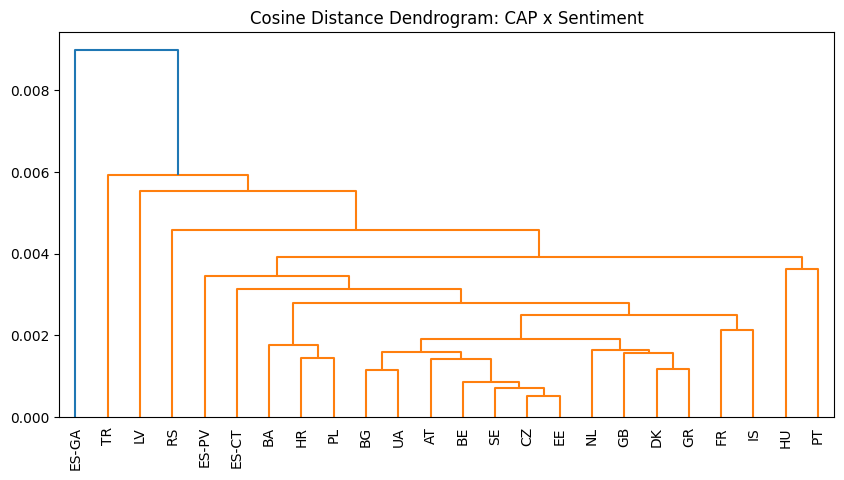

In [4]:
# ---- 1. Pivot data: rows = country, columns = CAP_category, values = mean sentiment ----
country_cap_sent = (
    filtered_all
    .groupby(["country", "CAP_category"])["sent_logit"]
    .mean()
    .unstack(fill_value=0) 
)

# ---- 2. Compute cosine distance between countries ----
cosine_matrix = cosine_distances(country_cap_sent.values)

# ---- 2.1. Convert to readable DataFrame ----
cosine_df = pd.DataFrame(
    cosine_matrix,
    index=country_cap_sent.index,
    columns=country_cap_sent.index
)

# --- 2.2. Round to 3 decimals and display cosine distance DataFrame ----
cosine_df = cosine_df.round(5)
print(cosine_df)

# ---- 2.2. Convert cosine distance matrix into a condensed matrix (required by linkage)
condensed = squareform(cosine_matrix, checks=False)


# ---- 3. Plot dendrograms ----
linked = linkage(condensed, method="average") 

plt.figure(figsize=(10, 5))
dendrogram(linked, labels=country_cap_sent.index.tolist(), leaf_rotation=90)
plt.title("Cosine Distance Dendrogram: CAP x Sentiment")
plt.show()

**5. Find the nearest neighbors (3 most similar countries)**

For each country, find the **three most similar countries** based on cosine distance (the 'nearest neighbors').

In [5]:
# ----- 4. Find the 3 most similar countries ----
masked_dist_df = cosine_df.mask(np.eye(len(cosine_df), dtype=bool))
nearest_neighbors = masked_dist_df.apply(lambda row: row.nsmallest(3).index.tolist(), axis=1)

# ---- 4.1. Display the results ----
for country, neighbors in nearest_neighbors.items():
    print(f"{country}: {', '.join(neighbors)}")

AT: BE, EE, GR
BA: EE, UA, PL
BE: EE, SE, CZ
BG: UA, EE, BE
CZ: EE, SE, BE
DK: GR, GB, NL
EE: CZ, SE, BE
ES-CT: GB, DK, CZ
ES-GA: CZ, SE, UA
ES-PV: UA, BG, NL
FR: EE, CZ, IS
GB: DK, SE, EE
GR: DK, AT, EE
HR: PL, CZ, UA
HU: CZ, HR, EE
IS: CZ, BE, GB
LV: EE, BG, FR
NL: DK, BE, EE
PL: HR, UA, BA
PT: SE, CZ, IS
RS: PL, GR, HR
SE: EE, BE, CZ
TR: PL, GB, CZ
UA: EE, BG, BE


**6. Compare sentiment across all parties, coalition and opposition**

Compare the **sentiment of CAP categories across all countries, coalition and opposition** and visualize their similarity using three side-by-side dendrograms

C:\Users\isabe\AppData\Local\Temp\ipykernel_1804\1727390824.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["country", "CAP_category"])["sent_logit"]


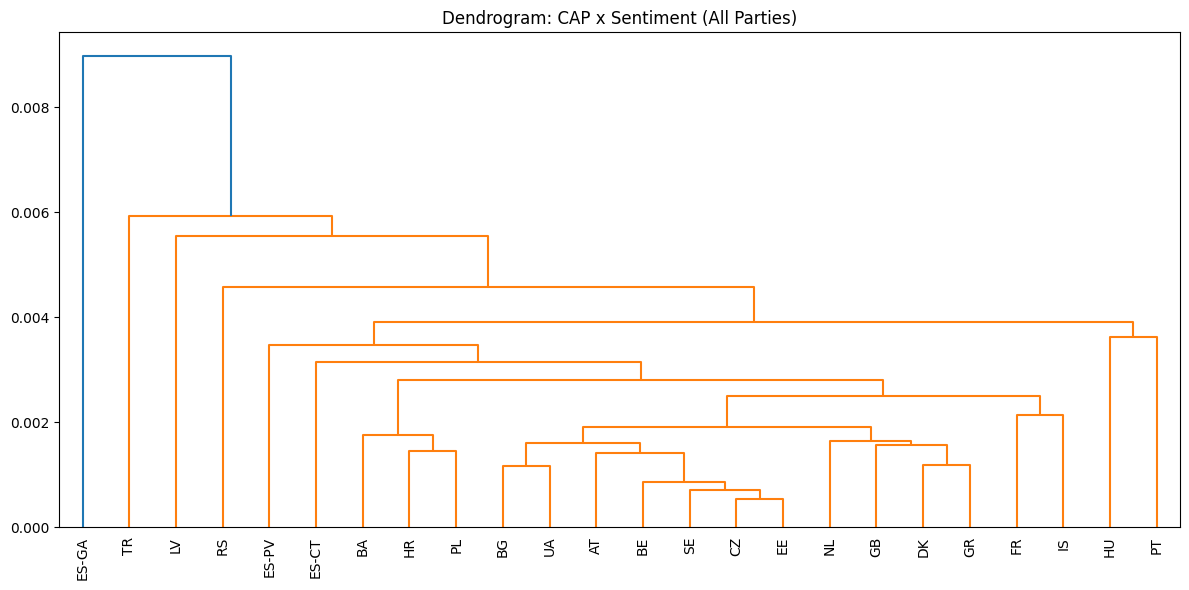

In [7]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

# ---- 1. Pivot data: rows = country, columns = CAP_category, values = mean sentiment ----
country_cap_sent = (
    filtered_all
    .groupby(["country", "CAP_category"])["sent_logit"]
    .mean()
    .unstack(fill_value=0)
)

# ---- 2. Calculate cosine distances ----
cosine_matrix = cosine_distances(country_cap_sent.values)

# ---- 3. Create condensed matrix for linkage ----
condensed = squareform(cosine_matrix, checks=False)

# ---- 4. Linkage and dendrogram ----
linked = linkage(condensed, method="average")

plt.figure(figsize=(12,6))
dendrogram(linked, labels=country_cap_sent.index.tolist(), leaf_rotation=90)
plt.title("Dendrogram: CAP x Sentiment (All Parties)")
plt.tight_layout()
plt.show()

**7. Cosine distance for CAP category distribution (word counts)**

Build cosine distance tables across countries for **CAP category distributions based on word counts** (instead of mean sentiment) and **visualize** the results using **dendrograms**.

country     AT     BA     BE     BG     CZ     DK  ES-CT  ES-GA  ES-PV     FR  \
country                                                                         
AT       0.000  0.264  0.152  0.075  0.054  0.111  0.143  0.130  0.069  0.076   
BA       0.264  0.000  0.395  0.224  0.221  0.439  0.274  0.450  0.355  0.320   
BE       0.152  0.395  0.000  0.128  0.168  0.134  0.299  0.245  0.181  0.110   
BG       0.075  0.224  0.128  0.000  0.039  0.184  0.182  0.148  0.121  0.060   
CZ       0.054  0.221  0.168  0.039  0.000  0.173  0.148  0.106  0.100  0.055   
DK       0.111  0.439  0.134  0.184  0.173  0.000  0.229  0.219  0.147  0.119   
ES-CT    0.143  0.274  0.299  0.182  0.148  0.229  0.000  0.135  0.091  0.117   
ES-GA    0.130  0.450  0.245  0.148  0.106  0.219  0.135  0.000  0.084  0.071   
ES-PV    0.069  0.355  0.181  0.121  0.100  0.147  0.091  0.084  0.000  0.063   
FR       0.076  0.320  0.110  0.060  0.055  0.119  0.117  0.071  0.063  0.000   
GB       0.179  0.334  0.119

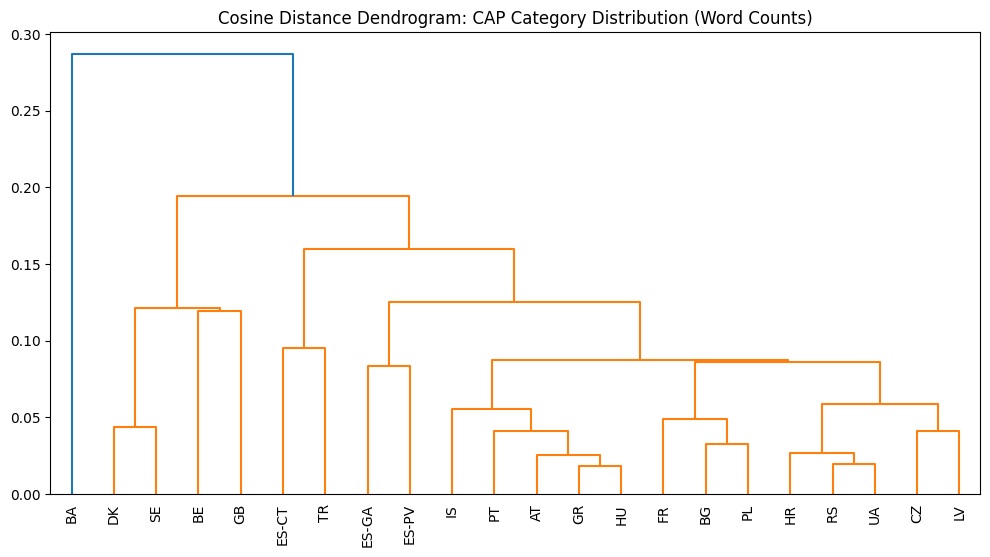

In [ ]:
# ---- 1. Pivot data: rows = country, columns = CAP_category, values = total word count ----
country_cap_words = (
    filtered_all
    .groupby(["country", "CAP_category"])["word_count"]  # using word counts instead of sentiment
    .sum()
    .unstack(fill_value=0)
)

# ---- 2. Compute cosine distance between countries ----
cosine_matrix = cosine_distances(country_cap_words.values)

# ---- 2.1. Convert to readable DataFrame ----
cosine_df = pd.DataFrame(
    cosine_matrix,
    index=country_cap_words.index,
    columns=country_cap_words.index
)

# ---- 2.2. Round to 3 decimals and display ----
cosine_df = cosine_df.round(3)
print(cosine_df)

# ---- 2.3. Convert to condensed distance matrix (required by linkage) ----
condensed = squareform(cosine_matrix, checks=False)

# ---- 3. Plot dendrogram ----
linked = linkage(condensed, method="average")

plt.figure(figsize=(12, 6))
dendrogram(linked, labels=country_cap_words.index.tolist(), leaf_rotation=90)
plt.title("Cosine Distance Dendrogram: CAP Category Distribution (Word Counts)")
plt.show()

**8. Compare word counts for all / coalition / opposition side-by-side**

Compare the **distribution of CAP categories** (based on word counts) **across all countries, coalition and opposition** and visualize their similarity using three side-by-side dendrograms


Cosine distances for All parties:
 country       AT       BA       BE       BG       CZ       DK    ES-CT  \
country                                                                  
AT       0.00000  0.26429  0.15164  0.07536  0.05366  0.11068  0.14259   
BA       0.26429  0.00000  0.39477  0.22355  0.22088  0.43880  0.27433   
BE       0.15164  0.39477  0.00000  0.12772  0.16786  0.13399  0.29940   
BG       0.07536  0.22355  0.12772  0.00000  0.03867  0.18437  0.18152   
CZ       0.05366  0.22088  0.16786  0.03867  0.00000  0.17323  0.14848   
DK       0.11068  0.43880  0.13399  0.18437  0.17323  0.00000  0.22934   
ES-CT    0.14259  0.27433  0.29940  0.18152  0.14848  0.22934  0.00000   
ES-GA    0.13013  0.45033  0.24485  0.14848  0.10566  0.21891  0.13507   
ES-PV    0.06902  0.35464  0.18149  0.12052  0.10037  0.14741  0.09139   
FR       0.07606  0.32036  0.11018  0.06009  0.05548  0.11948  0.11716   
GB       0.17941  0.33375  0.11949  0.16645  0.17651  0.13307  0.24566   
GR

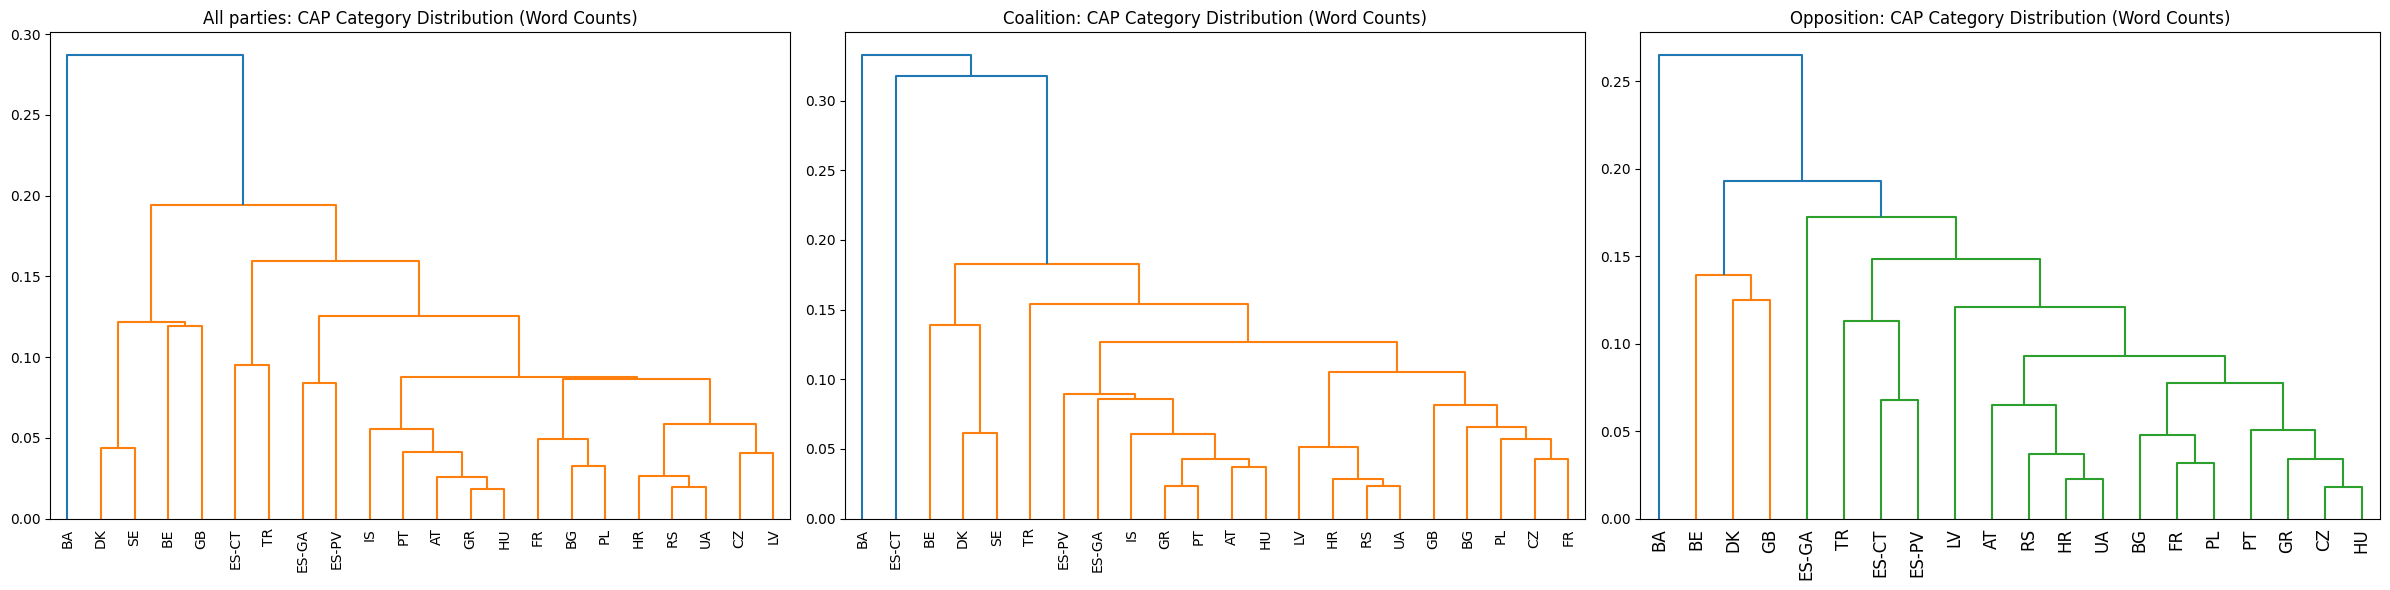

In [ ]:
# ---- 1. Datasets ----
datasets = {
    "All parties": filtered_all,
    "Coalition": filtered_all_coalition,
    "Opposition": filtered_all_opposition
}

# ---- 1.2. Loop through datasets ----
fig, axes = plt.subplots(1, 3, figsize=(24,6))

for ax, (name, df) in zip(axes, datasets.items()):

    # ---- 2.1. Pivot: country x CAP_category, total word count ----
    country_cap_words_coal_opp = df.groupby(["country", "CAP_category"])["word_count"].sum().unstack(fill_value=0)

    # ---- 2.2. Compute cosine distance ----
    cosine_matrix_cap_words_coal_opp = cosine_distances(country_cap_words_coal_opp.values)

    # ---- 2.3. Convert to readable DataFrame and round ----
    cosine_df_cap_words_coal_opp = pd.DataFrame(
        cosine_matrix_cap_words_coal_opp, 
        index=country_cap_words_coal_opp.index, 
        columns=country_cap_words_coal_opp.index
    ).round(5)
    
    print(f"\nCosine distances for {name}:\n", cosine_df_cap_words_coal_opp)

    # ---- 2.4. Convert to condensed distance matrix for linkage ----
    condensed_cap_words_coal_opp = squareform(cosine_matrix_cap_words_coal_opp, checks=False)

    # ---- 2.5. Linkage and dendrogram ----
    linked = linkage(condensed_cap_words_coal_opp, method="average")
    dendrogram(linked, labels=country_cap_words_coal_opp.index.tolist(), leaf_rotation=90, ax=ax)
    ax.set_title(f"{name}: CAP Category Distribution (Word Counts)")

plt.tight_layout()
plt.show()
